# Import Statements

In [136]:
!pip install category_encoders
!pip install pyclustering

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set_style('darkgrid')

from category_encoders import OrdinalEncoder
import pickle

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from pyclustering.cluster.kmedians import kmedians

# Data Preprocessing

## Data Loading

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
covtype_df = pd.read_csv("/content/drive/MyDrive/DMG Assignment 3/covtype_train.csv", skipinitialspace=True)
covtype_df

,Elevation,Aspect,Slope,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness,target
0,elevation_medium,aspect_medium,slope_low,hillshade_9am_max,hillnoon_max,0,1,low,22,0,2
1,elevation_high,aspect_medium,slope_low,hillshade_9am_max,hillnoon_max,1,1,mid,32,2,1
2,elevation_medium,aspect_low,slope_low,hillshade_9am_max,hillnoon_max,1,1,low,10,2,2
3,elevation_high,aspect_ultra,slope_medium,hillshade_9am_max,hillnoon_max,2,1,low,23,2,1
4,elevation_high,aspect_high,slope_low,hillshade_9am_max,hillnoon_max,2,1,mid,28,0,2
...,...,...,...,...,...,...,...,...,...,...,...
406703,elevation_ultra,aspect_medium,slope_low,hillshade_9am_max,hillnoon_max,1,1,mid,39,0,7
406704,elevation_medium,aspect_low,slope_medium,hillshade_9am_max,hillnoon_max,0,1,mid,28,0,2
406705,elevation_medium,aspect_medium,slope_low,hillshade_9am_max,hillnoon_max,0,1,mid,28,0,2
406706,elevation_high,aspect_high,slope_low,hillshade_9am_max,hillnoon_max,2,2,low,28,0,2


## Null Values 

In [140]:
covtype_df.isna().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Hillshade_9am                         0
Hillshade_Noon                        0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Fire_Points    0
Soil_Type                             0
Wilderness                            0
target                                0
dtype: int64

## Histogram

In [141]:
# no of uniuqe values correpsonding to each column
columns = list(covtype_df)
for column in columns:
  print(column, ': ', len(covtype_df[column].unique()))

Elevation :  4
Aspect :  4
Slope :  4
Hillshade_9am :  2
Hillshade_Noon :  2
Horizontal_Distance_To_Hydrology :  7
Vertical_Distance_To_Hydrology :  6
Horizontal_Distance_To_Fire_Points :  3
Soil_Type :  40
Wilderness :  4
target :  7


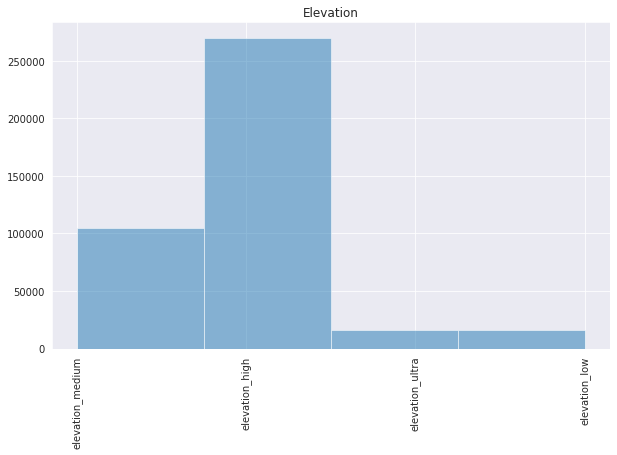

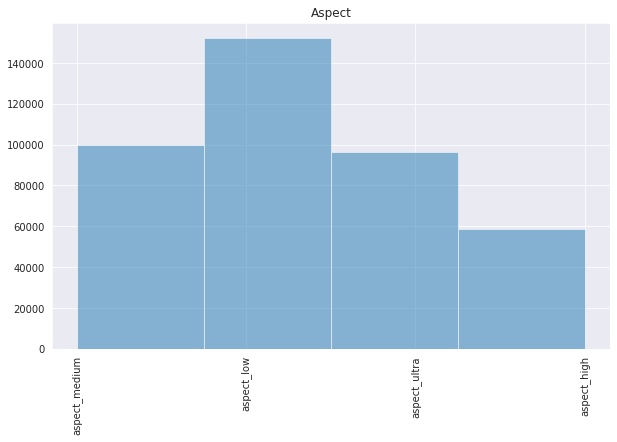

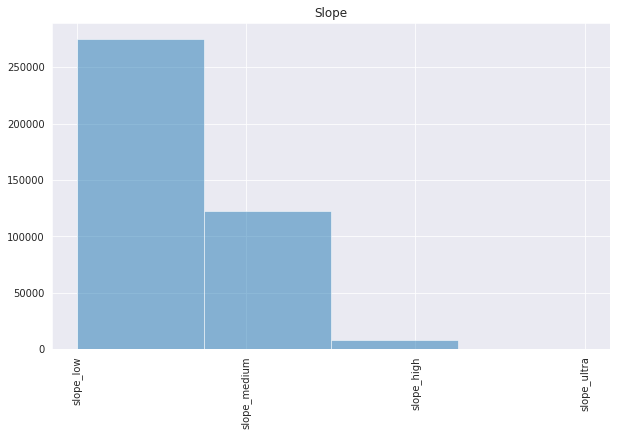

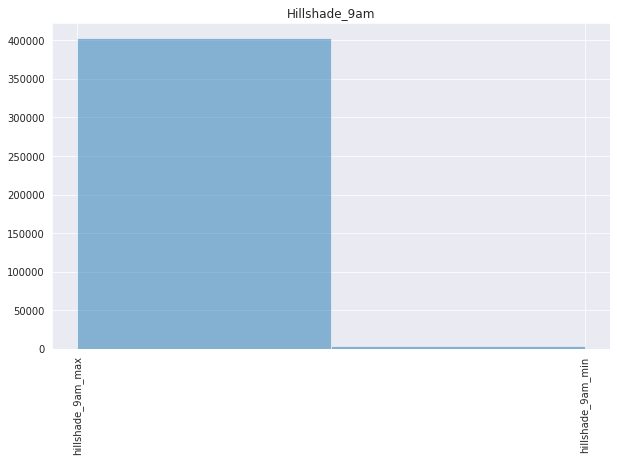

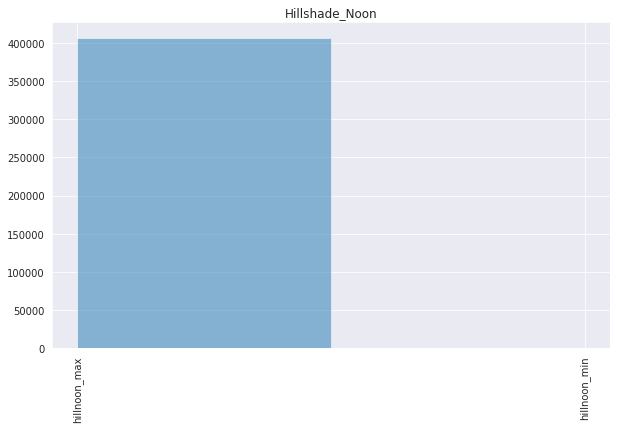

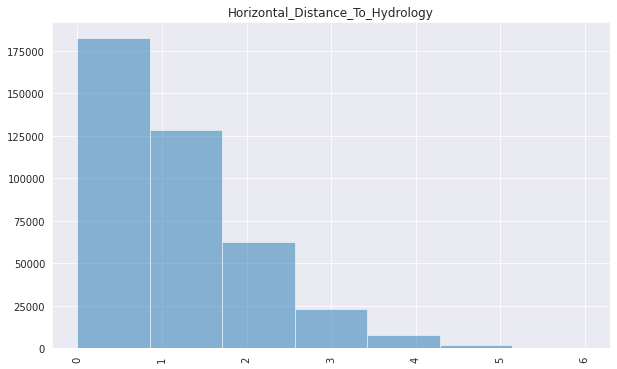

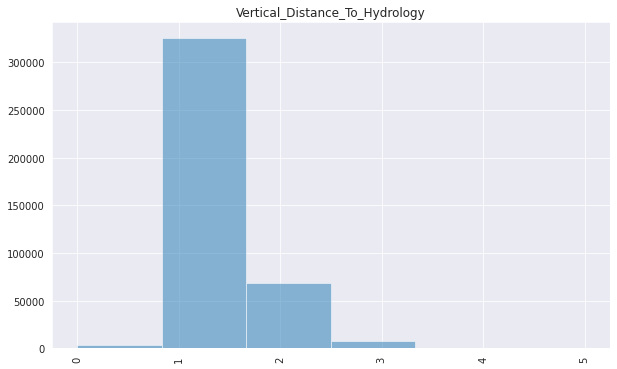

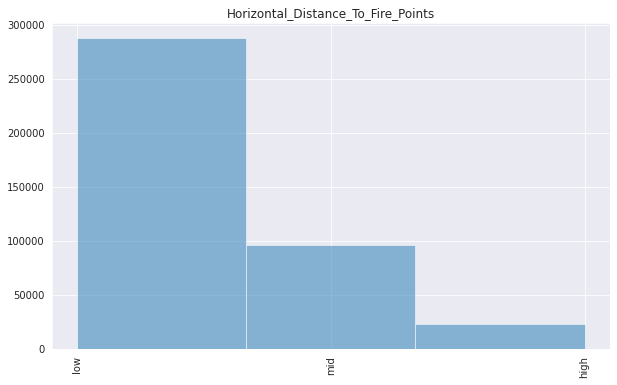

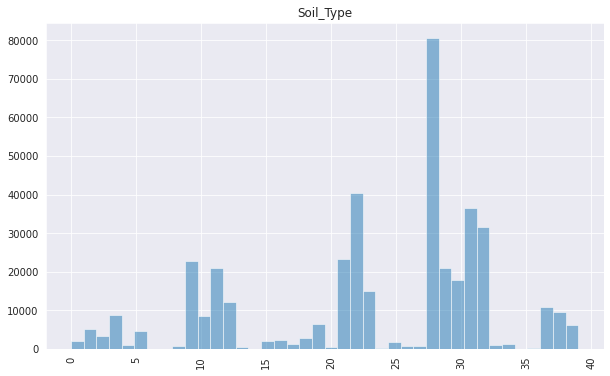

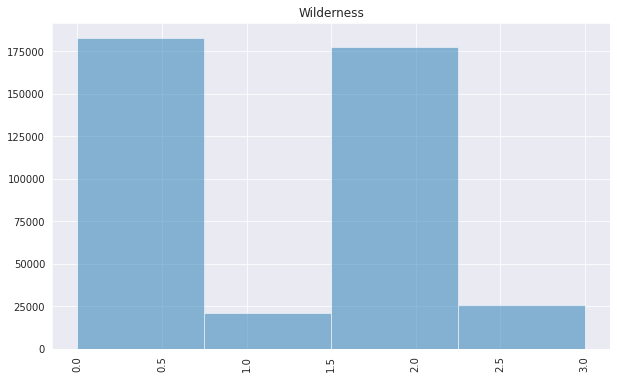

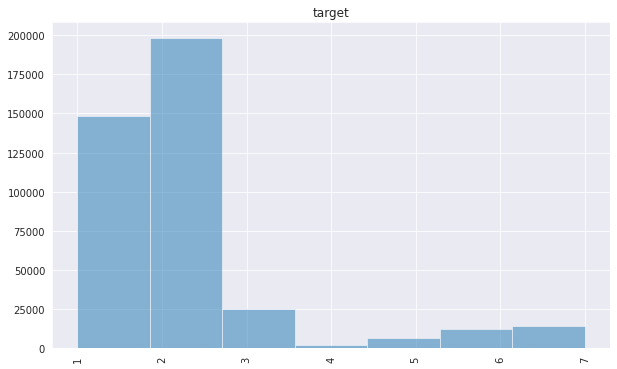

In [142]:
columns = list(covtype_df)

for column in columns:
  plt.figure(figsize=(10,6))
  plt.title(column)
  plt.xticks(rotation=90)
  covtype_df[column].hist(bins=len(covtype_df[column].unique()), alpha=0.5)
  plt.show()

## Drop Skewed Columns (More than 99% values are same)

In [143]:
total_count = covtype_df.shape[0]
for column in columns:
  skewed_percentage = len(covtype_df[covtype_df[column] == covtype_df[column].mode()[0]]) * 100/ total_count
  print(column, ' : ', skewed_percentage)

Elevation  :  66.35596054171543
Aspect  :  37.416524877799304
Slope  :  67.69008723703493
Hillshade_9am  :  99.01378876245366
Hillshade_Noon  :  99.92943340185096
Horizontal_Distance_To_Hydrology  :  44.87617651976357
Vertical_Distance_To_Hydrology  :  80.09849818543033
Horizontal_Distance_To_Fire_Points  :  70.73281076349618
Soil_Type  :  19.787169172969303
Wilderness  :  44.8791270395468
target  :  48.75979818444683


In [144]:
skewed_columns=['Hillshade_9am', 'Hillshade_Noon']
covtype_df.drop(columns=skewed_columns, inplace=True)
covtype_df.shape

(406708, 9)

## Duplicates

In [145]:
print("Actual rows: ", len(covtype_df.drop(['target'], axis=1)))
print("Duplicate rows: ", covtype_df.drop(['target'], axis=1).duplicated().sum())
print("Unique rows: ", len(covtype_df.drop(['target'], axis=1)) - covtype_df.drop(['target'], axis=1).duplicated().sum())

Actual rows:  406708
Duplicate rows:  398832
Unique rows:  7876


## Ordinal Encoding

In [146]:
encoding_scheme = { 'Elevation': {'elevation_low': 0, 'elevation_medium': 1, 'elevation_high': 2, 'elevation_ultra': 3},
                    'Aspect': {'aspect_low': 0, 'aspect_medium': 1, 'aspect_high': 2, 'aspect_ultra': 3},
                    'Slope': {'slope_low': 0, 'slope_medium': 1, 'slope_high': 2, 'slope_ultra': 3},
                    'Horizontal_Distance_To_Fire_Points': {'low': 0, 'mid': 1, 'high': 2}
                   }

categorical_col = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Fire_Points']

In [147]:
for column in categorical_col:
  encoder = OrdinalEncoder(cols = column, return_df = True, mapping=[{'col':column, 'mapping':encoding_scheme[column]}])
  covtype_df[column] = encoder.fit_transform(covtype_df[column])
  covtype_df[column] = covtype_df[column].astype(np.int64)

covtype_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness,target
0,1,1,0,0,1,0,22,0,2
1,2,1,0,1,1,1,32,2,1
2,1,0,0,1,1,0,10,2,2
3,2,3,1,2,1,0,23,2,1
4,2,2,0,2,1,1,28,0,2
...,...,...,...,...,...,...,...,...,...
406703,3,1,0,1,1,1,39,0,7
406704,1,0,1,0,1,1,28,0,2
406705,1,1,0,0,1,1,28,0,2
406706,2,2,0,2,2,0,28,0,2


## Correlation Matrix

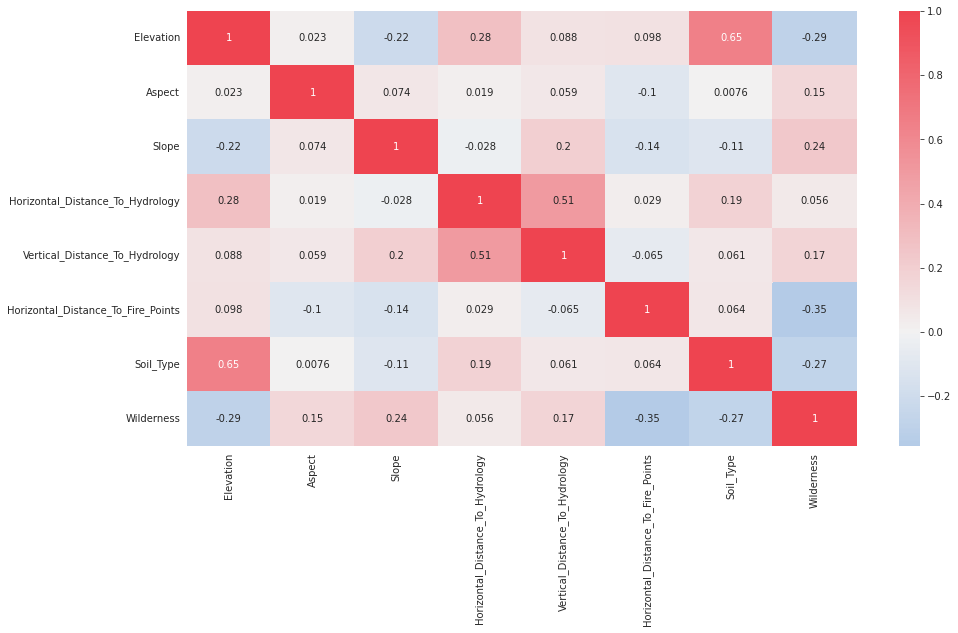

In [148]:
#correlation matrix
corrmat= covtype_df.drop(['target'], axis=1).corr()
plt.figure(figsize=(15,8)) 

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [149]:
# removing highly correlated features
covtype_df.drop(['Elevation'], axis=1, inplace=True)

## Split 

In [150]:
# sampling out to reduce the data size
covtype_df, _ = train_test_split(covtype_df, test_size=.8, random_state=42, stratify=covtype_df['target'])

In [151]:
target_df = pd.DataFrame(covtype_df['target'], columns=['target'])
covtype_df.drop(['target'], axis=1, inplace=True)

In [152]:
target_df

,target
265619,2
8210,1
319001,2
199965,3
113453,1
...,...
55764,2
170945,3
122632,2
367158,2


In [153]:
# freq based sorted out the cluster labels
sorted_actual_labels = target_df['target'].value_counts().sort_values(ascending=False).index.to_numpy()

In [154]:
covtype_df

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness
265619,3,0,1,1,2,11,0
8210,0,0,0,1,0,28,0
319001,3,1,1,1,0,31,2
199965,0,1,0,1,0,9,3
113453,1,0,0,1,1,22,0
...,...,...,...,...,...,...,...
55764,1,0,1,1,1,11,0
170945,3,2,0,2,0,9,3
122632,3,0,1,1,1,28,0
367158,1,0,1,1,1,28,0


# PCA

In [155]:
saved_columns = list(covtype_df)

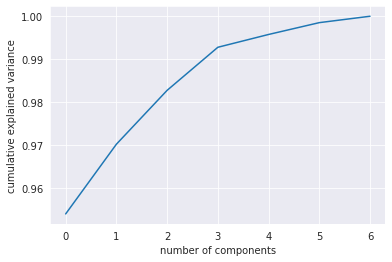

<Figure size 720x432 with 0 Axes>

In [156]:
pca = PCA().fit(covtype_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.figure(figsize=(10,6))
plt.show()

In [157]:
components = 2
pca = PCA(n_components = components)
pca_data = pca.fit_transform(covtype_df)
print('Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

Total Variance Explained: 97.02


In [158]:
pca_columns = []
for (item1, item2) in zip(['Feature '] * components, np.arange(1, components + 1, 1)):
    pca_columns.append(item1 + str(item2))

In [159]:
pca_covtype_df = pd.DataFrame(pca_data, columns=pca_columns)
pca_covtype_df

,Feature 1,Feature 2
0,12.327956,0.582382
1,-4.627845,-1.714749
2,-7.582696,2.053025
3,14.456202,-0.419211
4,1.362902,-1.068739
...,...,...
81336,12.333961,-0.958583
81337,14.456293,2.277483
81338,-4.655952,0.878826
81339,-4.653830,-0.797084


In [160]:
variance_list = pca.explained_variance_ratio_
mapped_weights = {}

for (item1, item2) in zip(pca_columns, variance_list):
    mapped_weights[item1] = item2

<BarContainer object of 2 artists>

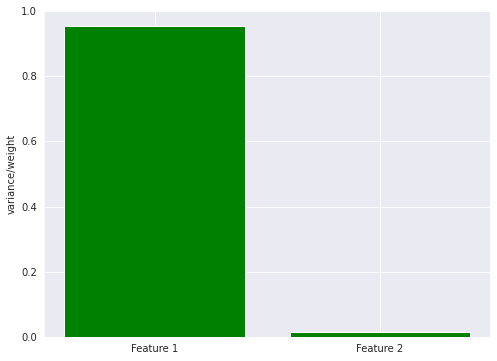

In [161]:
plt.figure(figsize=(8,6))
plt.ylabel('variance/weight')
plt.bar(mapped_weights.keys(), mapped_weights.values(), color='g')

# Q1

In [162]:
def mapped_labels(labels, centers):
  sorted_pred_labels = pd.Series(labels).value_counts().sort_values(ascending=False).index.to_numpy()
  mapping_dict = dict(zip(sorted_pred_labels, sorted_actual_labels))

  mapped_centers = centers.copy()
  for idx, (key, val) in enumerate(mapping_dict.items()):
    mapped_centers[val-1] = centers[key]
  
  return pd.Series(labels).replace(mapping_dict), mapped_centers

## KMeans

In [163]:
kmeans = KMeans(n_clusters=7, random_state=42).fit(pca_covtype_df)

In [164]:
# save the model to disk
pickle.dump(kmeans, open("kmeans.pkl", 'wb'))

In [165]:
kmeans_labels, kmeans_cluster_centers = mapped_labels(kmeans.labels_, kmeans.cluster_centers_)

In [166]:
covtype_df['Cluster'] = kmeans_labels
pca_covtype_df['Cluster'] = kmeans_labels

### Centroids

In [167]:
kmeans_centroids = pd.DataFrame(pca.inverse_transform(kmeans_cluster_centers), columns=saved_columns, index=range(1, 8))
kmeans_centroids

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness
1,1.905038,0.360435,1.240517,1.308837,0.276414,31.302343,1.232868
2,0.715536,0.265576,0.873959,1.154603,0.455902,28.313153,0.664890
3,1.186124,0.351169,0.862270,1.194005,0.354310,21.956019,1.123978
4,0.760753,0.338009,0.663499,1.129513,0.405285,17.630283,1.022110
5,1.616339,0.515773,0.570048,1.191193,0.206488,2.598478,1.964777
6,1.449226,0.275395,1.258799,1.271632,0.376175,37.794702,0.777786
7,1.263662,0.432677,0.640587,1.170185,0.294682,10.335208,1.528314


### Visualization

In [168]:
center_df = pd.DataFrame(kmeans_cluster_centers, columns=list(pca_covtype_df.drop(columns=['Cluster'])))
center_df['Cluster'] = pd.Series(len(pca_covtype_df) * ['centroid'])
visualisation_df = pd.concat([pca_covtype_df, center_df])

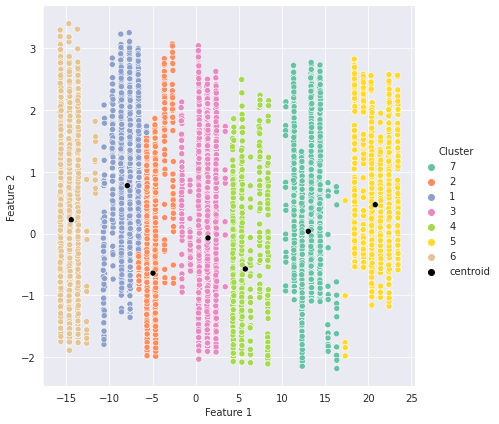

In [169]:
sns.relplot(x="Feature 1", y="Feature 2", hue="Cluster", data=visualisation_df, height=6, palette=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#000000"])

### Cluster Distribution

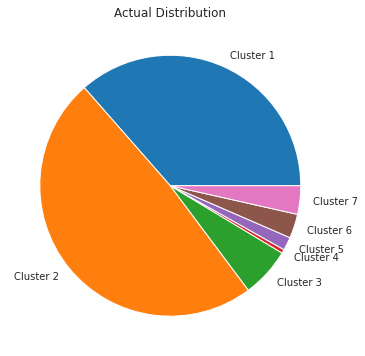

In [170]:
actual_clusters_count = []
for i in range(1,8):
  actual_clusters_count.append(len(target_df[target_df['target'] == i]))

clusters_name = []
for (item1, item2) in zip(['Cluster '] * len(actual_clusters_count), np.arange(1, len(actual_clusters_count) + 1, 1)):
    clusters_name.append(item1 + str(item2))

fig = plt.figure(figsize =(10,6))
plt.pie(actual_clusters_count, labels=clusters_name)
plt.title("Actual Distribution")
plt.show()

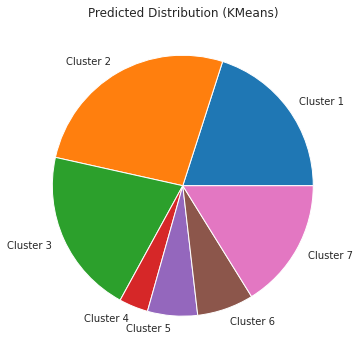

In [171]:
kmeans_clusters_count = []
for i in range(1,8):
  kmeans_clusters_count.append(len(covtype_df[covtype_df['Cluster'] == i]))

clusters_name = []
for (item1, item2) in zip(['Cluster '] * len(kmeans_clusters_count), np.arange(1, len(kmeans_clusters_count) + 1, 1)):
    clusters_name.append(item1 + str(item2))

fig = plt.figure(figsize =(10,6))
plt.pie(kmeans_clusters_count, labels=clusters_name)
plt.title("Predicted Distribution (KMeans)")
plt.show()

In [172]:
covtype_df.drop(['Cluster'], axis=1, inplace=True)
pca_covtype_df.drop(['Cluster'], axis=1, inplace=True)

## KMedian

In [173]:
initial_medians = pca_covtype_df.sample(7, random_state=42)
kmedians_instance = kmedians(pca_covtype_df, initial_medians)
kmedians_instance.process()

In [174]:
# save the model to disk
pickle.dump(kmedians_instance, open("kmedians.pkl", 'wb'))

In [175]:
kmedians_labels = [-1] * len(covtype_df)

for cluster in range(len(kmedians_instance.get_clusters())):
  for idx in kmedians_instance.get_clusters()[cluster]:
    kmedians_labels[idx] = cluster

In [176]:
kmedians_centers = kmedians_instance.get_medians()

In [177]:
kmedians_labels, kmedians_centers = mapped_labels(kmedians_labels, kmedians_centers)

In [178]:
covtype_df['Cluster'] = kmedians_labels
pca_covtype_df['Cluster'] = kmedians_labels

### Centroids

In [179]:
kmedians_centroids = pd.DataFrame(pca.inverse_transform(kmedians_centers), columns=saved_columns, index=range(1, 8))
kmedians_centroids

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness
1,3.087330,0.475536,1.536982,1.452775,0.084768,31.007871,1.898920
2,1.421910,0.373604,0.923090,1.222945,0.316421,21.978875,1.254273
3,0.696326,0.265587,0.863010,1.151418,0.457819,28.022867,0.663241
4,1.137807,0.467539,0.455420,1.133674,0.285104,2.975875,1.687166
5,0.864073,0.218378,1.112233,1.200415,0.471058,37.948324,0.447892
6,2.100665,0.399961,1.222799,1.323444,0.231672,28.040909,1.442949
7,1.065248,0.409235,0.604283,1.147884,0.329469,11.031699,1.396421


### Visualization

In [180]:
center_df = pd.DataFrame(kmedians_centers, columns=list(pca_covtype_df.drop(columns=['Cluster'])))
center_df['Cluster'] = pd.Series(len(pca_covtype_df) * ['centroid'])
visualisation_df = pd.concat([pca_covtype_df, center_df])

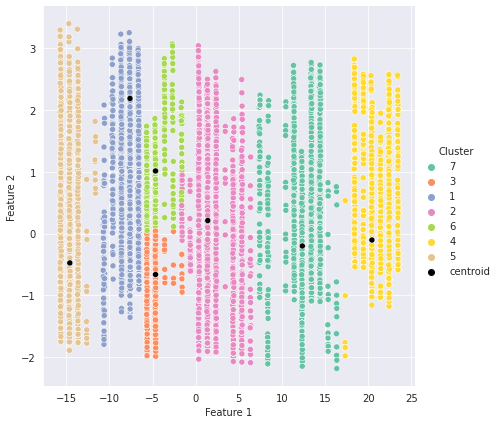

In [181]:
sns.relplot(x="Feature 1", y="Feature 2", hue="Cluster", data=visualisation_df, height=6, palette=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#000000"])

### Cluster Distribution

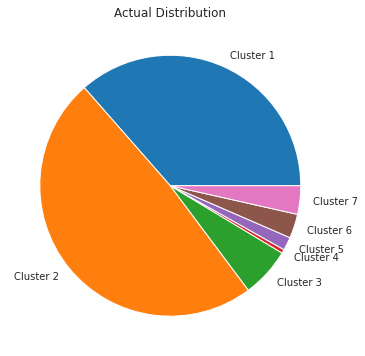

In [182]:
actual_clusters_count = []
for i in range(1,8):
  actual_clusters_count.append(len(target_df[target_df['target'] == i]))

clusters_name = []
for (item1, item2) in zip(['Cluster '] * len(actual_clusters_count), np.arange(1, len(actual_clusters_count) + 1, 1)):
    clusters_name.append(item1 + str(item2))

fig = plt.figure(figsize =(10,6))
plt.pie(actual_clusters_count, labels=clusters_name)
plt.title("Actual Distribution")
plt.show()

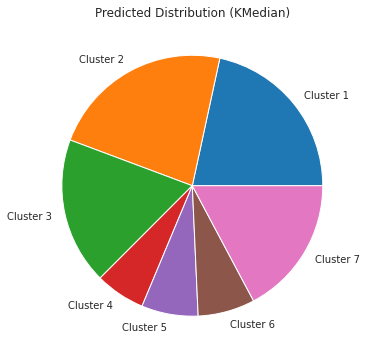

In [183]:
kmedians_clusters_count = []
for i in range(1,8):
    kmedians_clusters_count.append(len(covtype_df[covtype_df['Cluster'] == i]))

clusters_name = []
for (item1, item2) in zip(['Cluster '] * len(kmedians_clusters_count), np.arange(1, len(kmedians_clusters_count) + 1, 1)):
    clusters_name.append(item1 + str(item2))

fig = plt.figure(figsize =(10,6))
plt.pie(kmedians_clusters_count, labels=clusters_name)
plt.title("Predicted Distribution (KMedian)")
plt.show()

In [184]:
covtype_df.drop(['Cluster'], axis=1, inplace=True)
pca_covtype_df.drop(['Cluster'], axis=1, inplace=True)

## DBScan

In [185]:
db = DBSCAN(eps=1.0088,min_samples=100,metric='manhattan').fit(pca_covtype_df)

In [186]:
# save the model to disk
pickle.dump(db, open("dbscan.pkl", 'wb'))

In [187]:
db_labels = db.labels_

In [188]:
pca_covtype_df['Cluster'] = db_labels
db_centers = []

for x in list(set(db_labels)):
  samples = pca_covtype_df[pca_covtype_df['Cluster'] == x].drop(columns=['Cluster'])
  db_centers.append(samples.mean(axis=0).to_numpy())

pca_covtype_df.drop(['Cluster'], axis=1, inplace=True)

In [189]:
db_labels, db_centers = mapped_labels(db_labels, db_centers)

In [190]:
covtype_df['Cluster'] = db_labels
pca_covtype_df['Cluster'] = db_labels

### Centroids

In [191]:
db_centroids = pd.DataFrame(pca.inverse_transform(db_centers), columns=saved_columns, index=range(1, 8))
db_centroids

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness
1,1.125020,0.347545,0.839371,1.185521,0.362736,21.606656,1.100889
2,1.217656,0.305358,1.029544,1.219827,0.380302,29.615922,0.903376
3,1.265125,0.432784,0.641070,1.170379,0.294468,10.340437,1.528964
4,2.266771,0.442231,1.179361,1.331929,0.188140,23.905563,1.663795
5,1.140526,0.387744,0.717121,1.170010,0.335605,15.533817,1.298289
6,1.621336,0.516317,0.571112,1.191775,0.205642,2.588153,1.967874
7,1.446361,0.275059,1.258267,1.271309,0.376676,37.804422,0.775892


### Visualization

In [192]:
center_df = pd.DataFrame(db_centers, columns=list(pca_covtype_df.drop(columns=['Cluster'])))
center_df['Cluster'] = pd.Series(len(pca_covtype_df) * ['centroid'])
visualisation_df = pd.concat([pca_covtype_df, center_df])

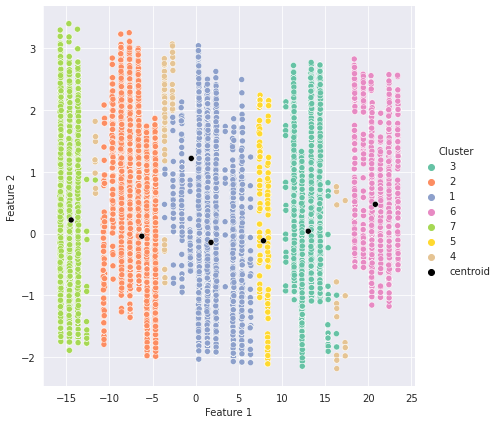

In [193]:
sns.relplot(x="Feature 1", y="Feature 2", hue="Cluster", data=visualisation_df, height=6, palette=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#000000"])

### Cluster Distribution

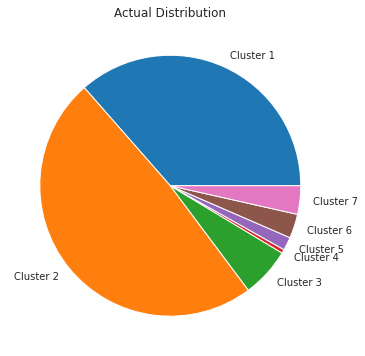

In [194]:
actual_clusters_count = []
for i in range(1,8):
  actual_clusters_count.append(len(target_df[target_df['target'] == i]))

clusters_name = []
for (item1, item2) in zip(['Cluster '] * len(actual_clusters_count), np.arange(1, len(actual_clusters_count) + 1, 1)):
    clusters_name.append(item1 + str(item2))

fig = plt.figure(figsize =(10,6))
plt.pie(actual_clusters_count, labels=clusters_name)
plt.title("Actual Distribution")
plt.show()

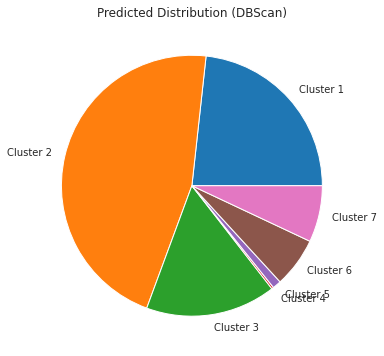

In [195]:
db_clusters_count = []
for i in range(1,8):
    db_clusters_count.append(len(covtype_df[covtype_df['Cluster'] == i]))

clusters_name = []
for (item1, item2) in zip(['Cluster '] * len(db_clusters_count), np.arange(1, len(db_clusters_count) + 1, 1)):
    clusters_name.append(item1 + str(item2))

fig = plt.figure(figsize =(10,6))
plt.pie(db_clusters_count, labels=clusters_name)
plt.title("Predicted Distribution (DBScan)")
plt.show()

In [196]:
covtype_df.drop(['Cluster'], axis=1, inplace=True)
pca_covtype_df.drop(['Cluster'], axis=1, inplace=True)

## GaussianMixture

In [197]:
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=42)

In [198]:
gmm_labels = gmm.fit_predict(pca_covtype_df)

In [199]:
# save the model to disk
pickle.dump(gmm, open("gaussian.pkl", 'wb'))

In [200]:
gmm_centers = np.empty(shape=(gmm.n_components, pca_covtype_df.shape[1]))

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(pca_covtype_df)
    gmm_centers[i, :] = pca_covtype_df.iloc[np.argmax(density)]

In [201]:
gmm_labels, gmm_centers = mapped_labels(gmm_labels, gmm_centers)

In [202]:
covtype_df['Cluster'] = gmm_labels
pca_covtype_df['Cluster'] = gmm_labels

### Centroids

In [203]:
gmm_centroids = pd.DataFrame(pca.inverse_transform(gmm_centers), columns=saved_columns, index=range(1, 8))
gmm_centroids

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness
1,1.196129,0.352147,0.864766,1.195221,0.352686,21.952906,1.129634
2,1.314182,0.312504,1.061089,1.232591,0.366088,29.945045,0.946775
3,1.210126,0.429268,0.621285,1.162856,0.302213,10.065730,1.506946
4,1.528446,0.517788,0.513540,1.175738,0.214009,0.962004,1.966815
5,0.816078,0.341032,0.685077,1.137312,0.397821,17.987226,1.041753
6,1.591478,0.510570,0.572884,1.189417,0.212289,3.041102,1.937204
7,1.453535,0.274953,1.262688,1.272544,0.376024,37.928778,0.776012


### Visualization

In [204]:
center_df = pd.DataFrame(gmm_centers, columns=list(pca_covtype_df.drop(columns=['Cluster'])))
center_df['Cluster'] = pd.Series(len(pca_covtype_df) * ['centroid'])
visualisation_df = pd.concat([pca_covtype_df, center_df])

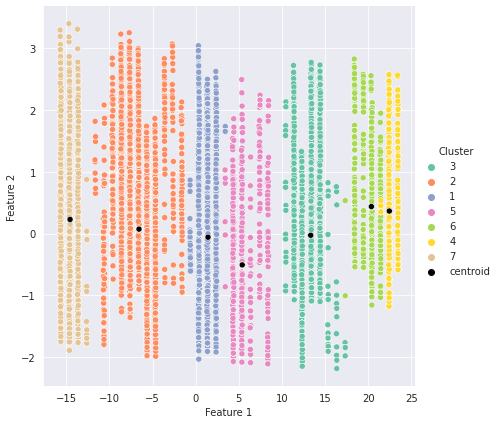

In [205]:
sns.relplot(x="Feature 1", y="Feature 2", hue="Cluster", data=visualisation_df, height=6, palette=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#000000"])

### Cluster Distribution

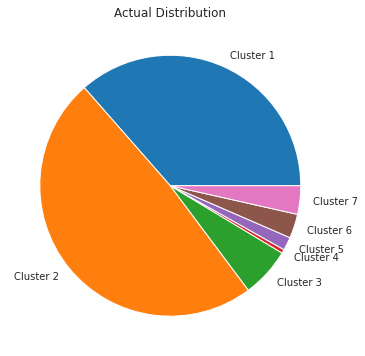

In [206]:
actual_clusters_count = []
for i in range(1,8):
  actual_clusters_count.append(len(target_df[target_df['target'] == i]))

clusters_name = []
for (item1, item2) in zip(['Cluster '] * len(actual_clusters_count), np.arange(1, len(actual_clusters_count) + 1, 1)):
    clusters_name.append(item1 + str(item2))

fig = plt.figure(figsize =(10,6))
plt.pie(actual_clusters_count, labels=clusters_name)
plt.title("Actual Distribution")
plt.show()

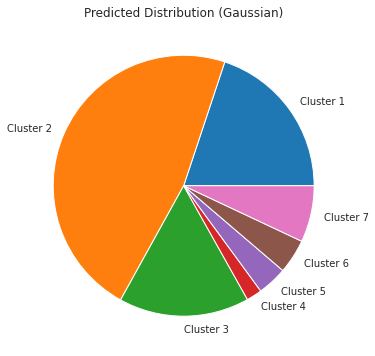

In [207]:
gmm_clusters_count = []
for i in range(1,8):
    gmm_clusters_count.append(len(covtype_df[covtype_df['Cluster'] == i]))

clusters_name = []
for (item1, item2) in zip(['Cluster '] * len(gmm_clusters_count), np.arange(1, len(gmm_clusters_count) + 1, 1)):
    clusters_name.append(item1 + str(item2))

fig = plt.figure(figsize =(10,6))
plt.pie(gmm_clusters_count, labels=clusters_name)
plt.title("Predicted Distribution (Gaussian)")
plt.show()

In [208]:
covtype_df.drop(['Cluster'], axis=1, inplace=True)
pca_covtype_df.drop(['Cluster'], axis=1, inplace=True)